# **1b_Cleaning/Preprocessing Twitter & Amazon Product Review dataset**

In this notebook we clean the following two datasets we are using for the sentiment analysis of this project.

- [Twitter](https://www.kaggle.com/datasets/gogylogy/twitterslang/data)
- [Amazon Product review](https://www.kaggle.com/datasets/arhamrumi/amazon-product-reviews/data)

## Loading libraries & Reading datasets

In [ ]:
import numpy as np
import pandas as pd
#import string
import re
import nltk.corpus  #pip install nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

df_twitter = pd.read_csv('Tweets.csv', names=['Target', 'Id', 'Date', 'Flag', 'User', 'Text'], encoding='latin-1')
df_amazon = pd.read_csv('Reviews.csv')
df_slang1 = pd.read_csv('slang.csv')
df_slangTwitter = pd.read_csv('twitterSlang.csv')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alerc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploring datasets
After reading our datasets and store them in a dataframe we explore the dataset by reviewing its underlying statistics, structure, different kind of values and its characteristics.

In [ ]:
def explore_data(df):
    display(print("General Info about df:\n"), df.info())
    display("General Description about df:\n",df.describe())
    display("DF Head:\n", df.head())
    display("Value Counts in Column Text\n", df.value_counts(df['Text']))
    print(df.hist(bins=50, figsize=(10,7)))

def explore_data2(df):
    #check for values in flag column other than NO_QUERY, null/nan values etc.
    for i in df.columns:
        print()
        print("Column:", i)
        print("List of Unique Values:", df[i].unique()) #unqiue values
        print("Length of the List with Unique Values:",len(df[i].unique())) #unqiue values
        #print(df[i].unique().sum()) #sum of unique values
        print("Counter Not-Null-Values", df[i].notnull().sum()) #sum of not null values
        print("Counter Not-NA-Values", df[i].notna().sum()) #sum of not null values

## Data Cleaning
Based on these points and cross checking certain rows manually, we concluded the data cleaning steps needed to have dataset with a satisfingly data quality.
This is achieved by passing our datasets to the function **clean_df(df)**.

We would like to mention the key steps done in this function:
- Add column Original Text to review the changes made in this function
- Lowercasing the text
- Remove duplicates, null values & empty strings
- Clean the text by removing Links, HTML tags, Usernames, Retweets, multiple Spaces/dots and other special characters


In addititon to that we would like to specifically mention that we tried remove stop words. When doing that we recognized that this preprocessing step would remove certain slang words, which are candidate words to be removed.





In [ ]:
def clean_df(df):
    df['Original Text'] = df['Text'] #create new column Original Text
    df['Text'] = df['Text'].str.lower() #lowercase all text
    #df['Text'] = df['Text'].str.strip() #remove leading and trailing whitespaces

    # remove duplicates, empty strings, null values
    df.drop_duplicates(subset=['Text'], inplace=True) #drop duplicates in column Text
    df.drop(df[df['Text'] == ''].index, inplace = True) #drop empty strings in column Text
    df.dropna(inplace=True) #drop null values --> there are no null values in the Twitter Dataset

    #clean text
    df['Text'] = df['Text'].str.replace(' +', ' ', regex=True) #remove multiple spaces
    df['Text'] = df['Text'].str.replace('\n', '', regex=True) #remove line breaks
    df['Text'] = df['Text'].str.replace('http\S+|www.\S+', '', regex=True) #remove links
    df['Text'] = df['Text'].str.replace('<[^<]+?>', '', regex=True) #remove html tags
    df['Text'] = df['Text'].str.replace('@\S+', '', regex=True)# remove usernames
    df['Text'] = df['Text'].str.replace('#\S+', '', regex=True) # remove hashtags
    #df['Text'] = df['Text'].str.replace(r'\.{3,}', '.', regex=True)  # remove multiple dots
    df['Text'] = df['Text'].str.replace('[\n!"#%&()*+,-/:;<=>?@[\\]^_`{|}~]', '', regex=True) #remove punctuation and special characters --> string.punctuation without: "'", ".", "$", "[^\w\s]|"
    df['Text'] = df['Text'].str.replace('[^\x00-\x7F]+', '', regex=True) #remove unicode characters
    #df['Text'] = df['Text'].str.replace('\d+', '', regex=True) #remove numbers --> do we want to remove numbers? --> discuss with Szymon
    #stop = stopwords.words('english') #remove stop words --> not necessary because we will use a CountVectorizer or Not??

    # rearrange dataframe
    df.sort_values(by=['Sentiment'], inplace=True)
    df.reset_index(drop=True, inplace=True) #reset index

    return df

# Twitter

The Twitter dataset contains 1.6 milion tweets with the following 6 attributes:

- <strong>Target</strong>: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- <strong>Id</strong>: The id of the tweet (2087)
- <strong>Date</strong>: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
- <strong>Flag</strong>: The query (lyx). If there is no query, then this value is NO_QUERY.
- <strong>User</strong>: the user that tweeted (robotickilldozr)
- <strong>Text</strong>: the text of the tweet (Lyx is cool)

Below you can find some general information like the metadata, basic statistics and the first 5 data records of our dataset

General Info about df:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   Target  1600000 non-null  int64 
 1   Id      1600000 non-null  int64 
 2   Date    1600000 non-null  object
 3   Flag    1600000 non-null  object
 4   User    1600000 non-null  object
 5   Text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


None

None

'General Description about df:\n'

,Target,Id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


'DF Head:\n'

,Target,Id,Date,Flag,User,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


'Value Counts in Column Text\n'

Text
isPlayer Has Died! Sorry                                                                                                                                               210
good morning                                                                                                                                                           118
headache                                                                                                                                                               115
Good morning                                                                                                                                                           112
Headache                                                                                                                                                               106
                                                                                                                                            

[[<Axes: title={'center': 'Target'}> <Axes: title={'center': 'Id'}>]]


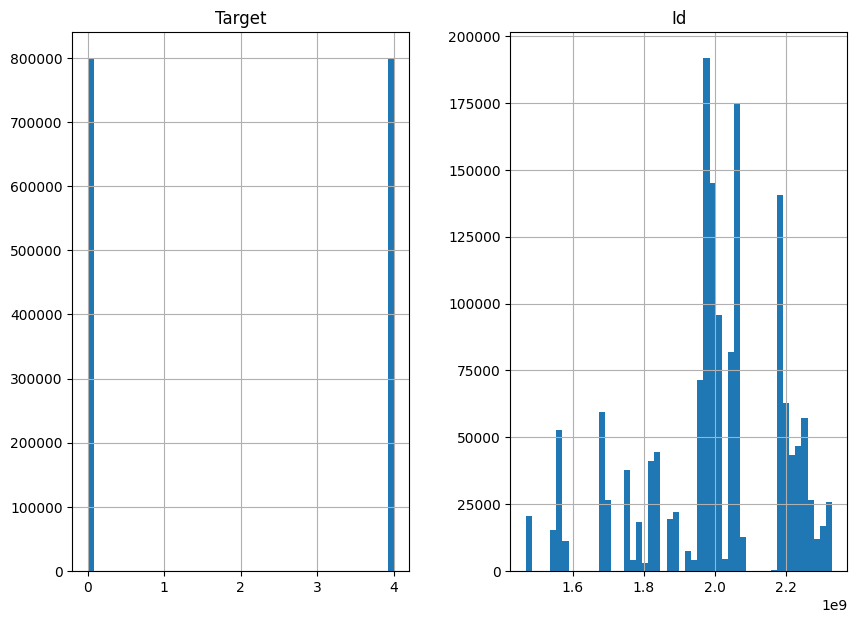

In [ ]:
explore_data(df_twitter)

## Observations Twitter dataset

It can be observed, that the "Twitter" dataset has 1.6 million data records with no empty, null or na values in it. However, we can observe that there are some duplicates in our "Text" column, which means these are Tweets that have been posted or retweetet multiple times.

The histogram demonstrates the the dataset has balanced "Target" values (each 800k). However, we would like to have a binary value for further processing, as it might make our life easier. Thus, we replace values 4 with 1.

For the analysis of this project we only need the column **"Text"** as our input feature and column **"Target"** which serves as label vector. Based on the aforementioned feature descriptions we have decided to drop all the other columns <strong>Date, Flag, ID and User</strong>.


In [ ]:
explore_data2(df_twitter)


Column: Target
List of Unique Values: [0 4]
Length of the List with Unique Values: 2
Counter Not-Null-Values 1600000
Counter Not-NA-Values 1600000

Column: Id
List of Unique Values: [1467810369 1467810672 1467810917 ... 2193601991 2193602064 2193602129]
Length of the List with Unique Values: 1598315
Counter Not-Null-Values 1600000
Counter Not-NA-Values 1600000

Column: Date
List of Unique Values: ['Mon Apr 06 22:19:45 PDT 2009' 'Mon Apr 06 22:19:49 PDT 2009'
 'Mon Apr 06 22:19:53 PDT 2009' ... 'Tue Jun 16 08:38:58 PDT 2009'
 'Tue Jun 16 08:39:00 PDT 2009' 'Tue Jun 16 08:40:50 PDT 2009']
Length of the List with Unique Values: 774363
Counter Not-Null-Values 1600000
Counter Not-NA-Values 1600000

Column: Flag
List of Unique Values: ['NO_QUERY']
Length of the List with Unique Values: 1
Counter Not-Null-Values 1600000
Counter Not-NA-Values 1600000

Column: User
List of Unique Values: ['_TheSpecialOne_' 'scotthamilton' 'mattycus' ... 'EvolveTom'
 'AmandaMarie1028' 'bpbabe']
Length of the Li

## Further explorations on the Twitter dataset
Consequently, we consider only unique text as input and thus we reduce the data frame accordingly.

As stated above and as we can see here in column "Text" too, that there are duplicate tweets which need to be removed before using them for our model.

In [ ]:
df_twitter_cleaned = df_twitter.drop(['Id', 'Date', 'Flag', 'User'], axis=1, inplace=False) #drop columns Id, Date, Flag, User
df_twitter_cleaned['Target'].replace(to_replace=4, value=1, inplace=True) #replace 4 with 1 in column Target
df_twitter_cleaned.rename(columns={'Target':'Sentiment'}, inplace=True) #rename column Target to Sentiment --> inform Szymon
df_twitter_cleaned = clean_df(df_twitter_cleaned) #clean dataframe

df_twitter_cleaned.to_csv('twitter_cleaned_binary.csv', index=False) #save cleaned dataset to csv
display(df_twitter_cleaned)

,Sentiment,Text,Original Text
0,0,awww that's a bummer you shoulda got david carr of third day to do it d,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,0,oh dear who's upset you,"@jodiekearns oh dear , who's upset you?"
2,0,i just want to cuddle when he doesn't then i want to toss him,"@Ramen_Noodle I just want to cuddle. When he doesn't, then I want to toss him."
3,0,i miss my laptop workingg,i miss my laptop workingg
4,0,awe i'll let quotthe kidsquot know,@GNA515 awe I'll let &quot;the kids&quot; know.
...,...,...,...
1577438,1,sunburnt it hurts today amp night was good lyin watchin scooby doo i,sunburnt it hurts :/ today &amp; night was good lyin watchin scooby doo (i)
1577439,1,not as cute as bishop,@2Serenity not as cute as bishop
1577440,1,i get to see my big brother yippppppeeee im on top of the world,I GET TO SEE MY BIG BROTHER! YIPPPPPPEEEE! Im on top of the world
1577441,1,fantastic show loved it is there anywhere i can see the rest of the killers performance,@Wossy fantastic show!! loved it!! is there anywhere i can see the rest of the Killers performance?


# Amazon Product Reviews

The Amazon Product Review dataset contains nearly 600 thousands consumer reviews on various amazon products. This data set comes with the following 10 attributes:

- <strong>Id</strong>: unique identifier for each record ranging from 1 to 568'454
- <strong>ProductId</strong>: unique id for a specific product (f.e. B00813GRG4) --> Total#Products: 74,258
- <strong>UserId</strong>: unique id for each user --> Total#Users: 256'059
- <strong>ProfileName</strong>: Profile name of a user
- <strong>HelpfulnessNumerator</strong>: number of users who found the review helpful
- <strong>HelpfulnessDenominator</strong>: number of users who indicated whether they found the review helpful or not
- <strong>Score</strong>: User Rating between 1 and 5 (1=very negative, 2=negative, 3=neutral, 4 positive, 5=very positive)
- <strong>Time</strong>: TimeStamp when the review was created (from Oct. 1999- Oct. 2012)
- <strong>Summary</strong>: brief summary of the review (see column "Text")
- <strong>Text</strong>: the actual text of a specific review


Below you can find some general information like the metadata, basic statistics and the first 5 data records of our dataset.

General Info about df:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


None

None

'General Description about df:\n'

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


'DF Head:\n'

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than most.
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


'Value Counts in Column Text\n'

Text
This review will make me sound really stupid, but whatever. I don't really care as long as people find out what's real and can avoid my mistakes.<br /><br />I got my wonderful little sweet Bella Bean when she was a few days shy of three years old. She had been bounced around from house to house and eating whatever was cheap. I have had cats around me my entire life, for about twenty-five years now. My mother always just fed them whatever, the kinds of food you buy in the supermarket - Friskies, Nine Lives, Kit & Kaboodle, stuff like that. And our cats were always fine, at least in terms of their eating habits. They would eat in the morning, stop when they were done, come back, and eat some more when they got hungry.<br /><br />My housemate at the time was working for Hill's and assured me that this was the best food ever made, so great, so on and so forth. I now know that she is an utter buffoon, but I initially trusted her judgment, which is so unfortunate because she doesn't thi

[[<Axes: title={'center': 'Id'}>
  <Axes: title={'center': 'HelpfulnessNumerator'}>]
 [<Axes: title={'center': 'HelpfulnessDenominator'}>
  <Axes: title={'center': 'Score'}>]
 [<Axes: title={'center': 'Time'}> <Axes: >]]


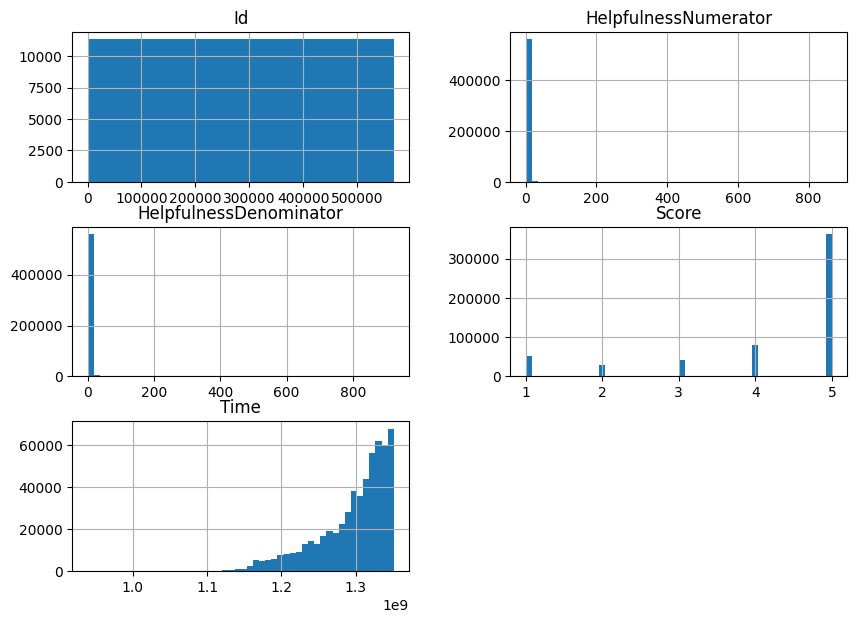

In [ ]:
explore_data(df_amazon)

## Observations Amazon Product Review dataset

It can be seen, that the "Amazon Product Review" dataset has 568'454 data records with a few empty, null or na values in columns "ProfileName" and "Summary".
Furthermore, we can observe that there are some duplicates in the "Text" column, which means these are Product Reviews that have been posted multiple times.
After exploring the dataset in a more detailed fashion, we have noticed, that some Users have bought the "same" product but for example in different colors, flavours etc. and copied there reviews multiple times.
Additionally, some Reviews have been posted more than once for the exact same product either by the same user or a different user.   

The histogram reveals that the dataset has imbalanced values in column "Score".
However, we would like to have two different datasets out of the Amazon Product Review dataset.

- One with binary value for "Score" for further processing, as it might make our life easier. Thus, we group scores 1&2 and label them as 0, while scores 4&5 will be labelled as 1. Since we assume a score of 3 stands for "neutral" Review, we negelect them and drop these data records. --> But this data set is not part of the scope of this project
- The second one with the inital Score values ranging from 1-5.

For the analysis of this project we only need the column **"Text"** as our input feature and column **"Score"** which serves as label vector. Based on the aforementioned feature descriptions we have decided to drop the columns <strong>Id, UserId, ProductId, ProfileName, Time, Summary, HelpfulnessNumerator and HelpfulnessDenominator</strong>.

In [ ]:
explore_data2(df_amazon)


Column: Id
List of Unique Values: [     1      2      3 ... 568452 568453 568454]
Length of the List with Unique Values: 568454
Counter Not-Null-Values 568454
Counter Not-NA-Values 568454

Column: ProductId
List of Unique Values: ['B001E4KFG0' 'B00813GRG4' 'B000LQOCH0' ... 'B003S1WTCU' 'B004I613EE'
 'B001LR2CU2']
Length of the List with Unique Values: 74258
Counter Not-Null-Values 568454
Counter Not-NA-Values 568454

Column: UserId
List of Unique Values: ['A3SGXH7AUHU8GW' 'A1D87F6ZCVE5NK' 'ABXLMWJIXXAIN' ... 'A28KG5XORO54AY'
 'A121AA1GQV751Z' 'A3LGQPJCZVL9UC']
Length of the List with Unique Values: 256059
Counter Not-Null-Values 568454
Counter Not-NA-Values 568454

Column: ProfileName
List of Unique Values: ['delmartian' 'dll pa' 'Natalia Corres "Natalia Corres"' ...
 'Lettie D. Carter' 'pksd "pk_007"' 'srfell17']
Length of the List with Unique Values: 218416
Counter Not-Null-Values 568428
Counter Not-NA-Values 568428

Column: HelpfulnessNumerator
List of Unique Values: [  1   0   3  

## Further exploration on the Amazon Product Review dataset

Consequently, we consider only unique text as input and thus we reduce the data frame accordingly.

As stated above and as we can see here in column "Text" too, that there are duplicate Product Reviews which need to be removed before using them for our model.


In [ ]:
df_amazon_cleaned = df_amazon.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time', 'Summary'], axis=1, inplace=False)
df_amazon_cleaned.rename(columns={'Score':'Sentiment'}, inplace=True) #rename column Score to Sentiment --> inform Szymon

df_amazon_cleaned = clean_df(df_amazon_cleaned) #clean dataframe
df_amazon_cleaned.to_csv('amazon_cleaned.csv', index=False) #save cleaned dataset to csv
display(df_amazon_cleaned)

,Sentiment,Text,Original Text
0,1,because of all the good reviews about blue buffalo dog food i've been using this expensive dog food for about 6 months i have 2 large dogs so sometimes i go through 5 cans a day i've mostly purchased through amazon this past order i opened a can of chicken pot pie which is supposed to be 'chunk' style with clearly identifiable peas potatoes etc this time i opened a can and it was mush food not knowing how it got messed up in the processing plant i did not feed it to my dogs thus losing the $230 that i paid for the can i immediately went to amazoncom and blue buffalo and wrote to their customer service departments about this neither company has contacted me back and that was 3 weeks ago so i decided to start randomly opening the other cans they all came in one 12can carton that was wrapped in plastic to see if all the cans were wrong fortunately they were not wrong so somehow the company mislabeled one of the cans during processing the reason that this could be extremely dangerous for us is if it was beef as one of my dogs has so many bowel issues after eating beef that i only give him poultry and fish products luckily i did not feed them this can and threw it away however this has tarnished my trust in this company at the very least either amazon or blue buffalo should have responded to my concerns i've been waiting to get an email asking for my 'review' because i feel this is the only forum that will give any attention to this potential problem that other people could experience my dogs are precious to me and i go to great lengths to exercise and nourish them which means i have to put trust in other companies to help me do just that i'm now looking for homemade dog food receipes and have started making some myself this past week i hope this was helpful to you,"Because of all the good reviews about Blue Buffalo dog food, I've been using this (expensive) dog food for about 6 months. I have 2 large dogs so sometimes I go through 5 cans a day. I've mostly purchased through Amazon. This past order, I opened a can of Chicken Pot Pie which is supposed to be 'chunk' style with clearly identifiable peas, potatoes, etc. This time, I opened a can and it was mush food. Not knowing how it got messed up in the processing plant, I did not feed it to my dogs (thus losing the $2.30 that I paid for the can). I immediately went to Amazon.com AND Blue Buffalo and wrote to their customer service departments about this. NEITHER company has contacted me back and that was 3 weeks ago! So, I decided to start randomly opening the other cans (they all came in one 12-can carton that was wrapped in plastic) to see if all the cans were wrong. Fortunately, they were not wrong so somehow the company mislabeled one of the cans during processing. The reason that this could be extremely dangerous for us is if it was beef as one of my dogs has so many bowel issues after eating beef that I only give him poultry and fish products. Luckily, I did not feed them this can and threw it away. However, this has tarnished my trust in this company. At the very least, either AMAZON or Blue Buffalo should have responded to my concerns. I've been waiting to get an email asking for my 'review' because I feel this is the only forum that will give any attention to this potential problem that other people could experience. My dogs are precious to me and I go to great lengths to exercise and nourish them which means I have to put trust in other companies to help me do just that. I'm now looking for homemade dog food receipes and have started making some myself this past week. I hope this was helpful to you."
1,1,please oh please someone tell me why i should pay 21 dollars for a 24 pack of soda that costs 7 bucks at any retail store this has to be a joke would give this zero stars if i could,"Please, oh please someone tell me why i should pay 21+ dollars for a 24 pack of soda that costs 7 bucks at ANY retail store... This has to be a joke. Would g

In [ ]:
df_amazon_cleaned_binary = df_amazon_cleaned.copy(deep=True) #create copy of df_twitter_cleaned
df_amazon_cleaned_binary.drop(df_amazon_cleaned_binary[df_amazon_cleaned['Sentiment'] == 3].index, inplace = True) #drop rows with Score 3 (around 30k rows)
df_amazon_cleaned_binary.replace(to_replace=1, value=0, inplace=True) #replace 1 with 0 in column Score
df_amazon_cleaned_binary.replace(to_replace=2, value=1, inplace=True) #replace 2 with 0 in column Score
df_amazon_cleaned_binary.replace(to_replace=4, value=1, inplace=True) #replace 4 with 1 in column Score
df_amazon_cleaned_binary.replace(to_replace=5, value=1, inplace=True) #replace 5 with 1 in column Score
df_amazon_cleaned_binary.to_csv('amazon_cleaned_binary.csv', index=False) #save cleaned dataset to csv
df_amazon_cleaned_binary.reset_index(drop=True, inplace=True) #reset index
print(df_amazon_cleaned_binary['Sentiment'].value_counts()) #check value counts in column Sentiment
display(df_amazon_cleaned_binary)

Sentiment
1    327542
0     36274
Name: count, dtype: int64


,Sentiment,Text,Original Text
0,0,because of all the good reviews about blue buffalo dog food i've been using this expensive dog food for about 6 months i have 2 large dogs so sometimes i go through 5 cans a day i've mostly purchased through amazon this past order i opened a can of chicken pot pie which is supposed to be 'chunk' style with clearly identifiable peas potatoes etc this time i opened a can and it was mush food not knowing how it got messed up in the processing plant i did not feed it to my dogs thus losing the $230 that i paid for the can i immediately went to amazoncom and blue buffalo and wrote to their customer service departments about this neither company has contacted me back and that was 3 weeks ago so i decided to start randomly opening the other cans they all came in one 12can carton that was wrapped in plastic to see if all the cans were wrong fortunately they were not wrong so somehow the company mislabeled one of the cans during processing the reason that this could be extremely dangerous for us is if it was beef as one of my dogs has so many bowel issues after eating beef that i only give him poultry and fish products luckily i did not feed them this can and threw it away however this has tarnished my trust in this company at the very least either amazon or blue buffalo should have responded to my concerns i've been waiting to get an email asking for my 'review' because i feel this is the only forum that will give any attention to this potential problem that other people could experience my dogs are precious to me and i go to great lengths to exercise and nourish them which means i have to put trust in other companies to help me do just that i'm now looking for homemade dog food receipes and have started making some myself this past week i hope this was helpful to you,"Because of all the good reviews about Blue Buffalo dog food, I've been using this (expensive) dog food for about 6 months. I have 2 large dogs so sometimes I go through 5 cans a day. I've mostly purchased through Amazon. This past order, I opened a can of Chicken Pot Pie which is supposed to be 'chunk' style with clearly identifiable peas, potatoes, etc. This time, I opened a can and it was mush food. Not knowing how it got messed up in the processing plant, I did not feed it to my dogs (thus losing the $2.30 that I paid for the can). I immediately went to Amazon.com AND Blue Buffalo and wrote to their customer service departments about this. NEITHER company has contacted me back and that was 3 weeks ago! So, I decided to start randomly opening the other cans (they all came in one 12-can carton that was wrapped in plastic) to see if all the cans were wrong. Fortunately, they were not wrong so somehow the company mislabeled one of the cans during processing. The reason that this could be extremely dangerous for us is if it was beef as one of my dogs has so many bowel issues after eating beef that I only give him poultry and fish products. Luckily, I did not feed them this can and threw it away. However, this has tarnished my trust in this company. At the very least, either AMAZON or Blue Buffalo should have responded to my concerns. I've been waiting to get an email asking for my 'review' because I feel this is the only forum that will give any attention to this potential problem that other people could experience. My dogs are precious to me and I go to great lengths to exercise and nourish them which means I have to put trust in other companies to help me do just that. I'm now looking for homemade dog food receipes and have started making some myself this past week. I hope this was helpful to you."
1,0,please oh please someone tell me why i should pay 21 dollars for a 24 pack of soda that costs 7 bucks at any retail store this has to be a joke would give this zero stars if i could,"Please, oh please someone tell me why i should pay 21+ dollars for a 24 pack of soda that costs 7 bucks at ANY retail store... This has to be a joke. Would g

In [ ]:
df_amazon_1 = df_amazon.drop([], axis=1, inplace=False)
duplicateRows = df_amazon_1[df_amazon_1.duplicated(subset=['Text', "Score", "ProductId"], keep=False)].sort_values(by=['Text'])
display(duplicateRows)




,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
479890,479891,B000Z91YTC,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",6,6,5,1156723200,Golden Chai Must Be Experienced!,"*****<br /><br />Numi Tea's Golden Chai Spiced Assam Black Tea is a premium Numi tea, both certified organic and kosher. The ingredients are fair trade certified organic Assam black tea, organic cinnamon, organic Chinese ginger, organic green cardamom, and organic Turkish anise. There is nothing artificial in this or in any Numi tea.<br /><br />On the box, the manufacturer writes: ""Throughout India, chai stalls are a meeting place for provocative tea and conversation. From its homeland in China, chai has journeyed as chai, th&eacute;, and tea, recreating itself in every land. Numi's golden brewed, organic Chai fuses rich cultures in a complex and hearty Assam black tea. Indian cinnamon and mild green cardamom evoke a warm balance with the vitality of Chinese ginger. The peaked, sweet aroma of Turkish anise exhilarates memories. Reminisce in aged tradition with an inspiring cup of Golden Chai.""<br /><br />Although this is a ""chai"", note that it contains no sweeteners...I prefer this, and the anise gives a certain type of mild sweetness, but commercial chais often have sugar added, so be prepared for a wonderful no-calorie indulgence that is beautifully flavored but not ""sweet"" in the same way that sugar is. Golden Chai is also caffeinated; if you want a caffeine-free chai, try Numi Tea's Ruby Chai Spiced Rooibos Herbal Teasan instead.<br /><br />If you like Numi teas, get it---you won't be sorry. If you are new to Numi but love chai, this will probably be the best you've ever had.<br /><br />*****"
479892,479893,B000Z91YTC,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",2,2,5,1156723200,Golden Chai Must Be Experienced!,"*****<br /><br />Numi Tea's Golden Chai Spiced Assam Black Tea is a premium Numi tea, both certified organic and kosher. The ingredients are fair trade certified organic Assam black tea, organic cinnamon, organic Chinese ginger, organic green cardamom, and organic Turkish anise. There is nothing artificial in this or in any Numi tea.<br /><br />On the box, the manufacturer writes: ""Throughout India, chai stalls are a meeting place for provocative tea and conversation. From its homeland in China, chai has journeyed as chai, th&eacute;, and tea, recreating itself in every land. Numi's golden brewed, organic Chai fuses rich cultures in a complex and hearty Assam black tea. Indian cinnamon and mild green cardamom evoke a warm balance with the vitality of Chinese ginger. The peaked, sweet aroma of Turkish anise exhilarates memories. Reminisce in aged tradition with an inspiring cup of Golden Chai.""<br /><br />Although this is a ""chai"", note that it contains no sweeteners...I prefer this, and the anise gives a certain type of mild sweetness, but commercial chais often have sugar added, so be prepared for a wonderful no-calorie indulgence that is beautifully flavored but not ""sweet"" in the same way that sugar is. Golden Chai is also caffeinated; if you want a caffeine-free chai, try Numi Tea's Ruby Chai Spiced Rooibos Herbal Teasan instead.<br /><br />If you like Numi teas, get it---you won't be sorry. If you are new to Numi but love chai, this will probably be the best you've ever had.<br /><br />*****"
305532,305533,B00014DAHU,A1YUL9PCJR3JTY,"O. Brown ""Ms. O. Khannah-Brown""",1,1,5,1160006400,"Delightful, Tasty, Healthy Tea for Digestive Support...Superb!","*****<br /><br />This Lemon Ginger Tea from Yogi Tea is for easing occasional indigestion and gas, and for enhancing circulation. It's a delightful, all natural tea made from ginger root, lemon grass, lemon peel, licorice root, black pepper, peppermint leaf, natural lemon flavor, ascorbic acid, and natural licorice flavor. Most of the ingredients are organic. The taste is lemony, peppery, slightly herby and a little sweet, v